In [1]:
!pip install yfinance python-dotenv


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from datetime import datetime, timedelta
import yfinance as yf
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

np.random.seed(42)
load_dotenv()

True

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Financial Market Volatility & Correlation Study")

📊 Financial Market Volatility & Correlation Study


In [4]:
print("\n1️⃣ Setting up data sources...")

ALPHA_VANTAGE_API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY", "")
print(ALPHA_VANTAGE_API_KEY)

ASSETS = {
    'crypto': {
        'BTC': 'Bitcoin',
        'ETH': 'Ethereum',
        'ADA': 'Cardano'
    },
    'stocks': {
        'AAPL': 'Apple Inc.',
        'GOOGL': 'Google',
        'TSLA': 'Tesla',
        'SPY': 'S&P 500 ETF',
        'QQQ': 'NASDAQ ETF'
    },
    'commodities': {
        'GLD': 'Gold ETF',
        'SLV': 'Silver ETF',
        'USO': 'Oil ETF',
        'DBA': 'Agriculture ETF'
    }
}

print(f"Assets to analyze: {sum(len(v) for v in ASSETS.values())} total")
print("Categories:", list(ASSETS.keys()))


1️⃣ Setting up data sources...
27EDZZTMQJ4AJGYL
Assets to analyze: 12 total
Categories: ['crypto', 'stocks', 'commodities']


In [5]:
print("\n2️⃣ Collecting market data...")

def get_crypto_data_alphavantage(symbol, market='USD'):
    """Fetch crypto data from Alpha Vantage."""
    if not ALPHA_VANTAGE_API_KEY:
        print("⚠️  Error: Alpha Vantage API key is missing. Please set it in your .env file.")
        return None

    try:
        url = f"https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={market}&apikey={ALPHA_VANTAGE_API_KEY}"
        response = requests.get(url, timeout=10)
        data = response.json()
        print(data)
        # Check for API-specific error messages first
        if "Error Message" in data:
            print(f"⚠️  API Error for {symbol}: {data['Error Message']}")
            return None

        # Check for rate limit or other notes
        if "Note" in data:
            print(f"⚠️  API Note for {symbol}: {data['Note']}")
            # The Note usually indicates a temporary issue, so return None
            return None

        # Proceed with data processing only if a valid time series exists
        if "Time Series (Digital Currency Daily)" in data:
            df = pd.DataFrame(data["Time Series (Digital Currency Daily)"]).T
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()

            price_data = pd.DataFrame()
            price_data['open'] = df['1a. open (USD)'].astype(float)
            price_data['high'] = df['2a. high (USD)'].astype(float)
            price_data['low'] = df['3a. low (USD)'].astype(float)
            price_data['close'] = df['4a. close (USD)'].astype(float)
            price_data['volume'] = df['5. volume'].astype(float)

            return price_data
        else:
            # This handles any unexpected structure that isn't a known error message
            print(f"⚠️  Error fetching {symbol}: Unexpected API response structure.")
            return None

    except requests.exceptions.JSONDecodeError:
        print(f"⚠️  Error fetching {symbol}: The API response was not valid JSON. This may indicate an invalid API key or a temporary API issue.")
        return None
    except Exception as e:
        print(f"⚠️  Error fetching {symbol}: {e}")
        return None

def get_stock_data_yfinance(symbol, period='2y'):
    try:
        ticker = yf.Ticker(symbol)
        data = ticker.history(period=period)

        if data.empty:
            print(f"⚠️  No data found for {symbol}")
            return None

        data.columns = [col.lower() for col in data.columns]
        return data
    except Exception as e:
        print(f"⚠️  Error fetching {symbol}: {e}")
        return None


2️⃣ Collecting market data...


In [6]:
print("\n📥 Downloading data for all assets...")

all_data = {}
all_prices = pd.DataFrame()

# Get crypto data
print("\n🪙 Fetching cryptocurrency data...")
for symbol, name in ASSETS['crypto'].items():
    print(f"  Downloading {name} ({symbol})...")
    data = get_crypto_data_alphavantage(symbol)
    if data is not None:
        all_data[f"{symbol}_CRYPTO"] = data
        all_prices[f"{symbol}_CRYPTO"] = data['close']

# Get stock data
print("\n📈 Fetching stock market data...")
for symbol, name in ASSETS['stocks'].items():
    print(f"  Downloading {name} ({symbol})...")
    data = get_stock_data_yfinance(symbol)
    if data is not None:
        all_data[f"{symbol}_STOCK"] = data
        all_prices[f"{symbol}_STOCK"] = data['close']

# Get commodity data
print("\n🥇 Fetching commodity data...")
for symbol, name in ASSETS['commodities'].items():
    print(f"  Downloading {name} ({symbol})...")
    data = get_stock_data_yfinance(symbol)
    if data is not None:
        all_data[f"{symbol}_COMMODITY"] = data
        all_prices[f"{symbol}_COMMODITY"] = data['close']

# Align all price data to common dates
all_prices = all_prices.dropna()
print(f"\n✅ Data collection complete!")
print(f"   Total assets collected: {len(all_prices.columns)}")
print(f"   Date range: {all_prices.index.min().date()} to {all_prices.index.max().date()}")
print(f"   Total trading days: {len(all_prices)}")


📥 Downloading data for all assets...

🪙 Fetching cryptocurrency data...
{'Information': 'We have detected your API key as 27EDZZTMQJ4AJGYL and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
⚠️  Error fetching BTC: Unexpected API response structure.
{'Information': 'We have detected your API key as 27EDZZTMQJ4AJGYL and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
⚠️  Error fetching ETH: Unexpected API response structure.
{'Information': 'We have detected your API key as 27EDZZTMQJ4AJGYL and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
⚠️  Error fetching ADA: Unexpected API response st

In [7]:
print("\n4️⃣ Computing returns and basic statistics...")

returns = all_prices.pct_change().dropna()

# Return metrics
return_stats = pd.DataFrame({
    'Mean_Daily_Return': returns.mean(),
    'Std_Daily_Return': returns.std(),
    'Annualized_Return': returns.mean() * 252,
    'Annualized_Volatility': returns.std() * np.sqrt(252),
    'Sharpe_Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis(),
    'Min_Daily_Return': returns.min(),
    'Max_Daily_Return': returns.max()
})

return_stats = return_stats.round(4)

print("📊 Return Statistics Summary:")
print(return_stats.head(10))


4️⃣ Computing returns and basic statistics...
📊 Return Statistics Summary:
               Mean_Daily_Return  Std_Daily_Return  Annualized_Return  \
AAPL_STOCK                0.0006            0.0175             0.1630   
GOOGL_STOCK               0.0011            0.0186             0.2662   
TSLA_STOCK                0.0014            0.0400             0.3576   
SPY_STOCK                 0.0008            0.0104             0.2138   
QQQ_STOCK                 0.0010            0.0132             0.2487   
GLD_COMMODITY             0.0012            0.0100             0.2928   
SLV_COMMODITY             0.0011            0.0176             0.2796   
USO_COMMODITY             0.0002            0.0187             0.0570   
DBA_COMMODITY             0.0007            0.0096             0.1822   

               Annualized_Volatility  Sharpe_Ratio  Skewness  Kurtosis  \
AAPL_STOCK                    0.2783        0.5858    0.9460   13.9776   
GOOGL_STOCK                   0.2947        0

In [8]:
print("\n5️⃣ Analyzing volatility patterns...")

rolling_windows = [7, 30, 90]
volatility_data = {}

for window in rolling_windows:
    vol_name = f'volatility_{window}d'
    rolling_vol = returns.rolling(window=window).std() * np.sqrt(252)
    volatility_data[vol_name] = rolling_vol

asset_classes = ['CRYPTO', 'STOCK', 'COMMODITY']
volatility_comparison = {}

for asset_class in asset_classes:
    class_columns = [col for col in returns.columns if asset_class in col]
    if class_columns:
        class_volatility = returns[class_columns].std() * np.sqrt(252)
        volatility_comparison[asset_class] = {
            'average_volatility': class_volatility.mean(),
            'min_volatility': class_volatility.min(),
            'max_volatility': class_volatility.max(),
            'assets': class_volatility.to_dict()
        }

print("📈 Average Annualized Volatility by Asset Class:")
for asset_class, vol_data in volatility_comparison.items():
    print(f"   {asset_class}: {vol_data['average_volatility']:.2%}")
    print(f"     Range: {vol_data['min_volatility']:.2%} - {vol_data['max_volatility']:.2%}")


5️⃣ Analyzing volatility patterns...
📈 Average Annualized Volatility by Asset Class:
   STOCK: 31.65%
     Range: 16.48% - 63.49%
   COMMODITY: 22.23%
     Range: 15.29% - 29.74%


In [9]:
print("\n6️⃣ Computing correlation matrices...")

correlation_matrix = returns.corr()

rolling_correlation_periods = [30, 90, 180]
rolling_correlations = {}

major_assets = ['BTC_CRYPTO', 'SPY_STOCK', 'GLD_COMMODITY']
major_assets = [asset for asset in major_assets if asset in returns.columns]

if len(major_assets) >= 2:
    for period in rolling_correlation_periods:
        corr_name = f'rolling_corr_{period}d'
        rolling_correlations[corr_name] = {}

        for i, asset1 in enumerate(major_assets):
            for j, asset2 in enumerate(major_assets):
                if i < j:  # Avoid duplicate pairs
                    pair_name = f"{asset1}_vs_{asset2}"
                    rolling_corr = returns[asset1].rolling(window=period).corr(returns[asset2])
                    rolling_correlations[corr_name][pair_name] = rolling_corr

print("🔗 Correlation analysis complete")


6️⃣ Computing correlation matrices...
🔗 Correlation analysis complete


In [10]:
print("\n7️⃣ Running statistical tests...")

btc_returns = returns['BTC_CRYPTO'] if 'BTC_CRYPTO' in returns.columns else None
gold_returns = returns['GLD_COMMODITY'] if 'GLD_COMMODITY' in returns.columns else None

statistical_tests = {}

if btc_returns is not None and gold_returns is not None:
    # Levene's test for equal variances
    levene_stat, levene_p = stats.levene(btc_returns.dropna(), gold_returns.dropna())

    # F-test for variance ratio
    btc_var = btc_returns.var()
    gold_var = gold_returns.var()
    f_stat = btc_var / gold_var if gold_var > 0 else np.nan

    statistical_tests['BTC_vs_Gold_Volatility'] = {
        'BTC_Volatility': btc_returns.std() * np.sqrt(252),
        'Gold_Volatility': gold_returns.std() * np.sqrt(252),
        'Variance_Ratio_F_Stat': f_stat,
        'Levene_Test_Stat': levene_stat,
        'Levene_P_Value': levene_p,
        'Significantly_Different': levene_p < 0.05
    }

# Compare stock market vs crypto correlations
stock_columns = [col for col in returns.columns if 'STOCK' in col]
crypto_columns = [col for col in returns.columns if 'CRYPTO' in col]

if len(stock_columns) > 1:
    stock_corr_matrix = returns[stock_columns].corr()
    avg_stock_correlation = stock_corr_matrix.values[np.triu_indices_from(stock_corr_matrix.values, k=1)].mean()
    statistical_tests['Average_Stock_Correlation'] = avg_stock_correlation

if len(crypto_columns) > 1:
    crypto_corr_matrix = returns[crypto_columns].corr()
    avg_crypto_correlation = crypto_corr_matrix.values[np.triu_indices_from(crypto_corr_matrix.values, k=1)].mean()
    statistical_tests['Average_Crypto_Correlation'] = avg_crypto_correlation

# Normality tests for major assets
normality_tests = {}
for asset in major_assets:
    if asset in returns.columns:
        asset_returns = returns[asset].dropna()
        shapiro_stat, shapiro_p = stats.shapiro(asset_returns.sample(min(5000, len(asset_returns))))
        jarque_bera_stat, jarque_bera_p = stats.jarque_bera(asset_returns)

        normality_tests[asset] = {
            'Shapiro_Wilk_Stat': shapiro_stat,
            'Shapiro_Wilk_P_Value': shapiro_p,
            'Jarque_Bera_Stat': jarque_bera_stat,
            'Jarque_Bera_P_Value': jarque_bera_p,
            'Normal_Distribution': shapiro_p > 0.05 and jarque_bera_p > 0.05
        }

print("📊 Statistical tests completed")



7️⃣ Running statistical tests...
📊 Statistical tests completed


In [11]:
print("\n8️⃣ Computing beta coefficients...")

# Use SPY as market benchmark
market_benchmark = 'SPY_STOCK'
beta_coefficients = {}

if market_benchmark in returns.columns:
    market_returns = returns[market_benchmark]

    for asset in returns.columns:
        if asset != market_benchmark and not returns[asset].isna().all():
            asset_returns = returns[asset]

            # Remove NaN values for both series
            combined_data = pd.DataFrame({'asset': asset_returns, 'market': market_returns}).dropna()

            if len(combined_data) > 50:  # Ensure sufficient data points
                covariance = combined_data['asset'].cov(combined_data['market'])
                market_variance = combined_data['market'].var()

                beta = covariance / market_variance if market_variance > 0 else np.nan

                correlation = combined_data['asset'].corr(combined_data['market'])
                r_squared = correlation ** 2

                beta_coefficients[asset] = {
                    'Beta': beta,
                    'Correlation_with_Market': correlation,
                    'R_Squared': r_squared,
                    'Data_Points': len(combined_data)
                }

print(f"📈 Beta coefficients calculated for {len(beta_coefficients)} assets")


8️⃣ Computing beta coefficients...
📈 Beta coefficients calculated for 8 assets



9️⃣ Creating visualizations...


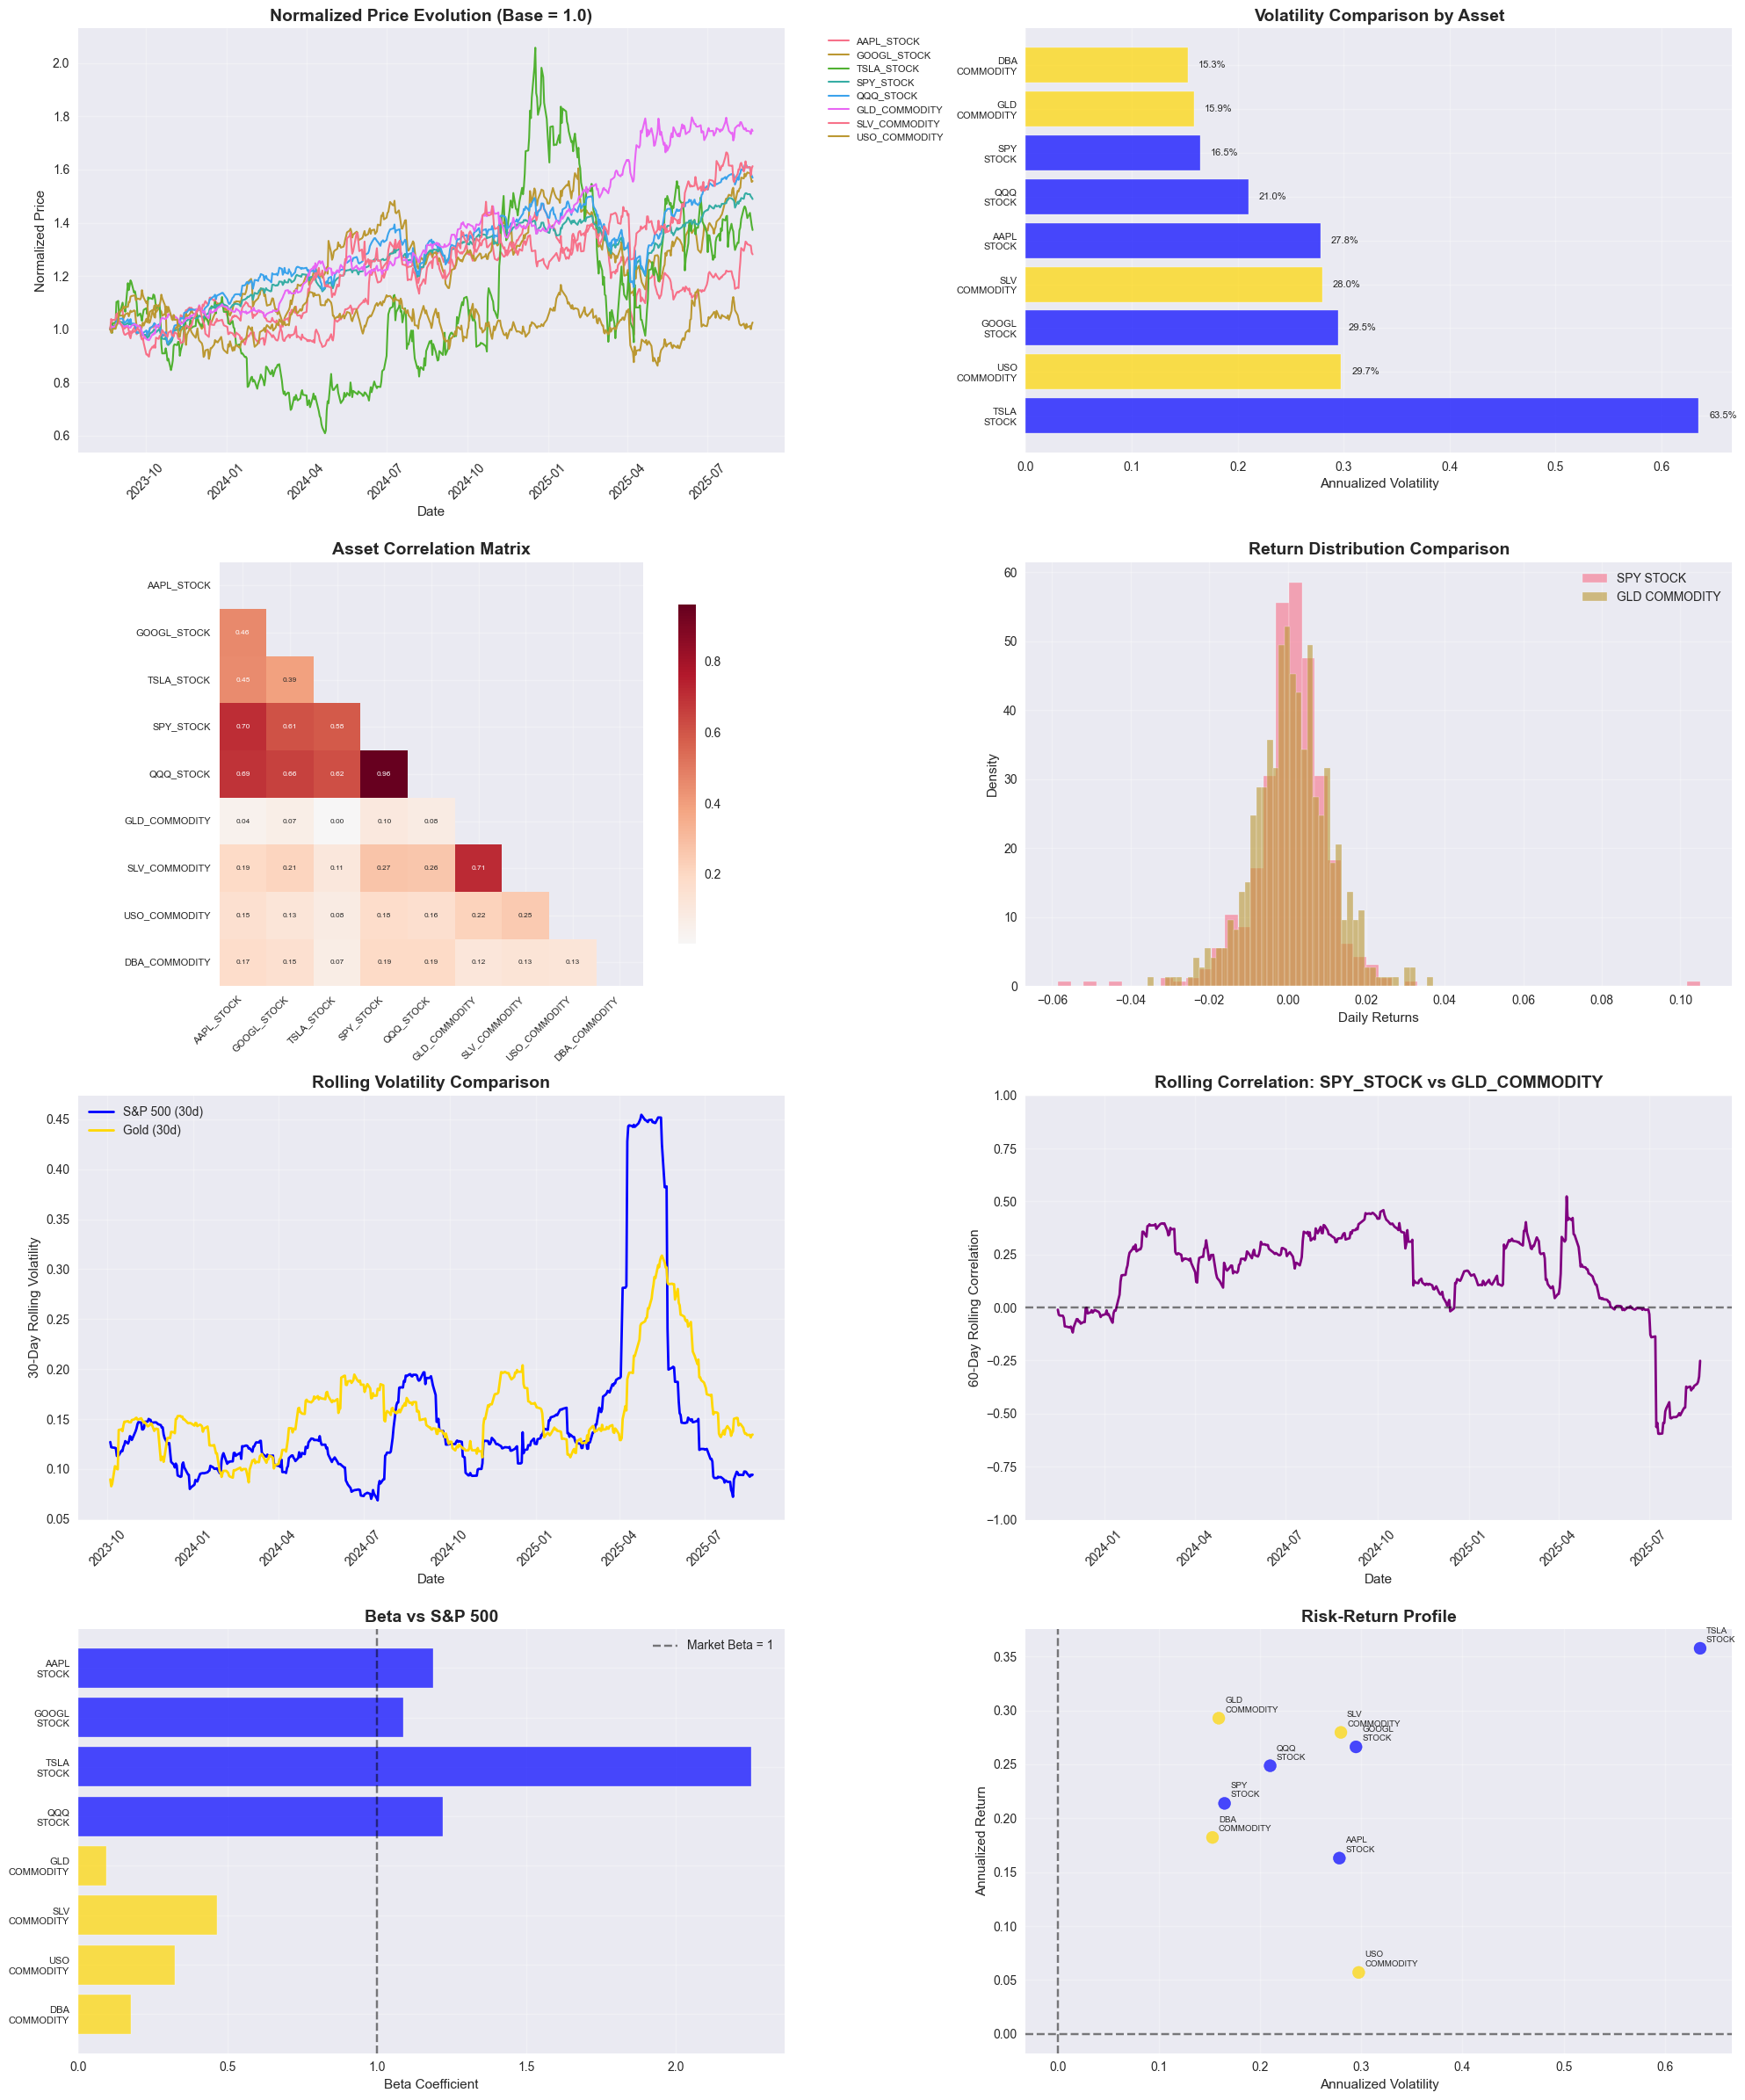

In [12]:
print("\n9️⃣ Creating visualizations...")

# Set up the plotting style
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

fig = plt.figure(figsize=(20, 24))

# Plot 1: Price evolution
plt.subplot(4, 2, 1)
for col in all_prices.columns[:8]:  # Limit to 8 assets for clarity
    normalized_prices = all_prices[col] / all_prices[col].iloc[0]
    plt.plot(all_prices.index, normalized_prices, label=col, linewidth=1.5)

plt.title('Normalized Price Evolution (Base = 1.0)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.xticks(rotation=45)

# Plot 2: Volatility comparison
plt.subplot(4, 2, 2)
vol_data = return_stats['Annualized_Volatility'].sort_values(ascending=True)
colors = ['red' if 'CRYPTO' in x else 'blue' if 'STOCK' in x else 'gold' for x in vol_data.index]
bars = plt.barh(range(len(vol_data)), vol_data.values, color=colors, alpha=0.7)
plt.yticks(range(len(vol_data)), [x.replace('_', '\n') for x in vol_data.index], fontsize=8)
plt.xlabel('Annualized Volatility')
plt.title('Volatility Comparison by Asset', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.1%}', ha='left', va='center', fontsize=8)

# Plot 3: Correlation heatmap
plt.subplot(4, 2, 3)
mask = np.triu(np.ones_like(correlation_matrix.values, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8}, annot_kws={'size': 6})
plt.title('Asset Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Plot 4: Return distribution comparison
plt.subplot(4, 2, 4)
for i, asset in enumerate(major_assets[:4]):  # Limit to 4 major assets
    if asset in returns.columns:
        asset_returns = returns[asset].dropna()
        plt.hist(asset_returns, bins=50, alpha=0.6, label=asset.replace('_', ' '), density=True)

plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Return Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# Plot 5: Rolling volatility
plt.subplot(4, 2, 5)
if 'BTC_CRYPTO' in returns.columns:
    btc_vol = returns['BTC_CRYPTO'].rolling(30).std() * np.sqrt(252)
    plt.plot(btc_vol.index, btc_vol, label='Bitcoin (30d)', color='orange', linewidth=2)

if 'SPY_STOCK' in returns.columns:
    spy_vol = returns['SPY_STOCK'].rolling(30).std() * np.sqrt(252)
    plt.plot(spy_vol.index, spy_vol, label='S&P 500 (30d)', color='blue', linewidth=2)

if 'GLD_COMMODITY' in returns.columns:
    gold_vol = returns['GLD_COMMODITY'].rolling(30).std() * np.sqrt(252)
    plt.plot(gold_vol.index, gold_vol, label='Gold (30d)', color='gold', linewidth=2)

plt.xlabel('Date')
plt.ylabel('30-Day Rolling Volatility')
plt.title('Rolling Volatility Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.xticks(rotation=45)

# Plot 6: Rolling correlation
plt.subplot(4, 2, 6)
if len(major_assets) >= 2 and all(asset in returns.columns for asset in major_assets[:2]):
    rolling_corr = returns[major_assets[0]].rolling(60).corr(returns[major_assets[1]])
    plt.plot(rolling_corr.index, rolling_corr, linewidth=2, color='purple')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('60-Day Rolling Correlation')
    plt.title(f'Rolling Correlation: {major_assets[0]} vs {major_assets[1]}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylim(-1, 1)

# Plot 7: Beta coefficients
plt.subplot(4, 2, 7)
if beta_coefficients:
    beta_values = {k: v['Beta'] for k, v in beta_coefficients.items() if not np.isnan(v['Beta'])}
    if beta_values:
        assets = list(beta_values.keys())
        betas = list(beta_values.values())
        colors = ['red' if 'CRYPTO' in x else 'blue' if 'STOCK' in x else 'gold' for x in assets]

        bars = plt.barh(range(len(assets)), betas, color=colors, alpha=0.7)
        plt.yticks(range(len(assets)), [x.replace('_', '\n') for x in assets], fontsize=8)
        plt.xlabel('Beta Coefficient')
        plt.title('Beta vs S&P 500', fontsize=14, fontweight='bold')
        plt.axvline(x=1, color='black', linestyle='--', alpha=0.5, label='Market Beta = 1')
        plt.legend()
        plt.gca().invert_yaxis()

# Plot 8: Risk-Return scatter
plt.subplot(4, 2, 8)
risk = return_stats['Annualized_Volatility']
returns_annual = return_stats['Annualized_Return']

colors = ['red' if 'CRYPTO' in x else 'blue' if 'STOCK' in x else 'gold' for x in risk.index]
plt.scatter(risk, returns_annual, c=colors, alpha=0.7, s=100)

for i, asset in enumerate(risk.index):
    plt.annotate(asset.replace('_', '\n'), (risk[asset], returns_annual[asset]),
                xytext=(5, 5), textcoords='offset points', fontsize=7)

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Risk-Return Profile', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [13]:
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS RESULTS")
print("="*80)

print(f"\n📊 DATA SUMMARY:")
print(f"   • Total assets analyzed: {len(all_prices.columns)}")
print(f"   • Analysis period: {all_prices.index.min().date()} to {all_prices.index.max().date()}")
print(f"   • Trading days: {len(all_prices)}")

print(f"\n📈 VOLATILITY RANKINGS (Annualized):")
vol_ranking = return_stats['Annualized_Volatility'].sort_values(ascending=False)
for i, (asset, vol) in enumerate(vol_ranking.head(10).items(), 1):
    print(f"   {i:2d}. {asset:<20} {vol:>8.2%}")

print(f"\n🔗 CORRELATION INSIGHTS:")
if 'Average_Stock_Correlation' in statistical_tests:
    print(f"   • Average stock-to-stock correlation: {statistical_tests['Average_Stock_Correlation']:.3f}")
if 'Average_Crypto_Correlation' in statistical_tests:
    print(f"   • Average crypto-to-crypto correlation: {statistical_tests['Average_Crypto_Correlation']:.3f}")

print(f"\n⚡ STATISTICAL TESTS:")
if 'BTC_vs_Gold_Volatility' in statistical_tests:
    test = statistical_tests['BTC_vs_Gold_Volatility']
    print(f"   Bitcoin vs Gold Volatility Test:")
    print(f"   • Bitcoin volatility: {test['BTC_Volatility']:.2%}")
    print(f"   • Gold volatility: {test['Gold_Volatility']:.2%}")
    print(f"   • Significantly different: {test['Significantly_Different']}")
    print(f"   • Variance ratio (F-stat): {test['Variance_Ratio_F_Stat']:.2f}")

print(f"\n🎯 BETA COEFFICIENTS (vs S&P 500):")
if beta_coefficients:
    beta_sorted = sorted(beta_coefficients.items(), key=lambda x: abs(x[1]['Beta']), reverse=True)
    for asset, stats in beta_sorted[:8]:
        print(f"   {asset:<20} Beta: {stats['Beta']:>6.2f} | R²: {stats['R_Squared']:>5.3f}")

print(f"\n💡 KEY INSIGHTS:")

if len(vol_ranking) > 0:
    most_volatile = vol_ranking.index[0]
    most_volatile_vol = vol_ranking.iloc[0]
    print(f"   • Most volatile asset: {most_volatile} ({most_volatile_vol:.1%} annual volatility)")

# Best Sharpe ratio
best_sharpe = return_stats['Sharpe_Ratio'].idxmax()
best_sharpe_value = return_stats.loc[best_sharpe, 'Sharpe_Ratio']
print(f"   • Best risk-adjusted returns: {best_sharpe} (Sharpe: {best_sharpe_value:.2f})")

# Highest correlation pair
if len(correlation_matrix) > 1:
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    max_corr_idx = upper_tri.stack().idxmax()
    max_corr_value = upper_tri.stack().max()
    print(f"   • Highest correlation: {max_corr_idx[0]} vs {max_corr_idx[1]} ({max_corr_value:.3f})")

# Asset class volatility comparison
if len(volatility_comparison) > 1:
    sorted_vol_classes = sorted(
        [(k, v['average_volatility']) for k, v in volatility_comparison.items()],
        key=lambda x: x[1],
        reverse=True
    )
    print(f"   • Most volatile asset class: {sorted_vol_classes[0][0]} ({sorted_vol_classes[0][1]:.1%})")
    print(f"   • Least volatile asset class: {sorted_vol_classes[-1][0]} ({sorted_vol_classes[-1][1]:.1%})")

print(f"\n📋 NORMALITY TEST RESULTS:")
if normality_tests:
    for asset, test_results in normality_tests.items():
        normal_status = "✅ Normal" if test_results['Normal_Distribution'] else "❌ Non-normal"
        print(f"   {asset:<20} {normal_status}")

print(f"\n📅 Analysis completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)


COMPREHENSIVE ANALYSIS RESULTS

📊 DATA SUMMARY:
   • Total assets analyzed: 9
   • Analysis period: 2023-08-22 to 2025-08-21
   • Trading days: 502

📈 VOLATILITY RANKINGS (Annualized):
    1. TSLA_STOCK             63.49%
    2. USO_COMMODITY          29.74%
    3. GOOGL_STOCK            29.47%
    4. SLV_COMMODITY          27.98%
    5. AAPL_STOCK             27.83%
    6. QQQ_STOCK              20.99%
    7. SPY_STOCK              16.48%
    8. GLD_COMMODITY          15.91%
    9. DBA_COMMODITY          15.29%

🔗 CORRELATION INSIGHTS:
   • Average stock-to-stock correlation: 0.613

⚡ STATISTICAL TESTS:

🎯 BETA COEFFICIENTS (vs S&P 500):
   TSLA_STOCK           Beta:   2.25 | R²: 0.342
   QQQ_STOCK            Beta:   1.22 | R²: 0.919
   AAPL_STOCK           Beta:   1.19 | R²: 0.495
   GOOGL_STOCK          Beta:   1.09 | R²: 0.371
   SLV_COMMODITY        Beta:   0.47 | R²: 0.075
   USO_COMMODITY        Beta:   0.32 | R²: 0.032
   DBA_COMMODITY        Beta:   0.18 | R²: 0.037
   GLD_CO

In [14]:
print(f"\n💾 Preparing data export...")

summary_export = pd.concat([
    return_stats,
    pd.DataFrame(volatility_comparison, index=['Average_Class_Volatility']).T.reindex(return_stats.index, fill_value=np.nan)
], axis=1)

if beta_coefficients:
    beta_df = pd.DataFrame(beta_coefficients).T
    summary_export = summary_export.join(beta_df, how='left')

print(f"   Export data prepared with {len(summary_export)} assets and {len(summary_export.columns)} metrics")
print(f"   Correlation matrix: {correlation_matrix.shape[0]}x{correlation_matrix.shape[1]}")

print(f"\n✅ Financial Market Volatility & Correlation Study Complete!")
print(f"   Study covers {len(all_prices.columns)} assets across {len(asset_classes)} asset classes")
print(f"   Analysis period: {len(all_prices)} trading days")
print(f"   Key findings: Volatility rankings, correlation patterns, beta coefficients, and statistical tests")


💾 Preparing data export...
   Export data prepared with 9 assets and 14 metrics
   Correlation matrix: 9x9

✅ Financial Market Volatility & Correlation Study Complete!
   Study covers 9 assets across 3 asset classes
   Analysis period: 502 trading days
   Key findings: Volatility rankings, correlation patterns, beta coefficients, and statistical tests


In [15]:
# Export summary results
summary_export.to_csv("financial_analysis_summary.csv", index=True)
summary_export.to_excel("financial_analysis_summary.xlsx", index=True)

# Export correlation matrix
correlation_matrix.to_csv("asset_correlations.csv")

print("✅ Results exported: financial_analysis_summary.csv, financial_analysis_summary.xlsx, asset_correlations.csv")


✅ Results exported: financial_analysis_summary.csv, financial_analysis_summary.xlsx, asset_correlations.csv


In [16]:
from pathlib import Path

html_report = f"""
<html>
<head>
    <title>Financial Market Volatility & Correlation Study</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        h1 {{ color: #2c3e50; }}
        h2 {{ color: #34495e; }}
        table {{ border-collapse: collapse; width: 100%; margin-bottom: 20px; }}
        th, td {{ border: 1px solid #ccc; padding: 8px; text-align: right; }}
        th {{ background-color: #f4f4f4; }}
    </style>
</head>
<body>
    <h1>📊 Financial Market Volatility & Correlation Study</h1>
    <h2>Summary Statistics</h2>
    {summary_export.head(20).to_html()}
    <h2>Correlation Matrix</h2>
    {correlation_matrix.to_html()}
    <h2>Key Insights</h2>
    <ul>
        <li>Most volatile asset: {most_volatile} ({most_volatile_vol:.1%} annual volatility)</li>
        <li>Best Sharpe ratio: {best_sharpe} ({best_sharpe_value:.2f})</li>
        <li>Highest correlation: {max_corr_idx[0]} vs {max_corr_idx[1]} ({max_corr_value:.3f})</li>
    </ul>
    <p><i>Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</i></p>
</body>
</html>
"""

Path("financial_report.html").write_text(html_report, encoding="utf-8")
print("✅ HTML report saved: financial_report.html")


✅ HTML report saved: financial_report.html
